In [118]:
# importing libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlp
import random
import string
import nltk # natural language toolkit to preprocess string

from autocorrect import Speller
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split

In [119]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


In [120]:
dataset = nlp.load_dataset('emotion')
dataset

Using custom data configuration default


{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [121]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [122]:
def get_tweet(data):
    tweets =[x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [123]:
tweets, labels = get_tweet(train)

In [124]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [125]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [126]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [127]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

(array([  8.,  45., 310., 488., 539., 625., 626., 629., 613., 636., 654.,
        655., 608., 622., 609., 603., 559., 535., 530., 510., 452., 430.,
        382., 385., 330., 327., 336., 317., 238., 208., 200., 200., 167.,
        157., 141., 144., 120., 117., 117.,  88.,  96.,  72.,  66.,  66.,
         65.,  52.,  37.,  43.,  30.,  32.,  31.,  26.,  30.,  20.,  23.,
         14.,   9.,  10.,   4.,   4.,   4.,   1.,   4.,   1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.]),
 <BarContainer object of 64 artists>)

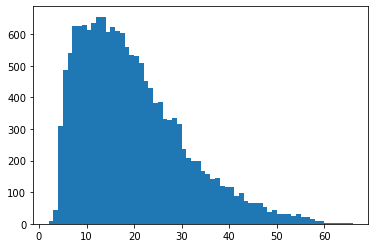

In [128]:
lengths = [len(t.split(' '))for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))

In [129]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [130]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded =pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [131]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [132]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [133]:
classes = set(labels)
print(classes)

{'fear', 'surprise', 'anger', 'joy', 'sadness', 'love'}


In [134]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [135]:
class_to_index

{'fear': 0, 'surprise': 1, 'anger': 2, 'joy': 3, 'sadness': 4, 'love': 5}

In [136]:
index_to_class

{0: 'fear', 1: 'surprise', 2: 'anger', 3: 'joy', 4: 'sadness', 5: 'love'}

In [137]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [138]:
train_labels  = names_to_ids(labels)
print(train_labels[0])

4


In [139]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [140]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [141]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [142]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [ ]:
h = model.fit(
    padded_train_seq, 
    train_labels, 
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 11s 16ms/step - loss: 1.2601 - accuracy: 0.5013 - val_loss: 0.7131 - val_accuracy: 0.7435
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5142 - accuracy: 0.8131 - val_loss: 0.5011 - val_accuracy: 0.8340
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3159 - accuracy: 0.8959 - val_loss: 0.4587 - val_accuracy: 0.8525
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2181 - accuracy: 0.9312 - val_loss: 0.4469 - val_accuracy: 0.8590
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1672 - accuracy: 0.9481 - val_loss: 0.4086 - val_accuracy: 0.8790
Epoch 6/20
123/500 [======>.......................] - ETA: 5s - loss: 0.1118 - accuracy: 0.9647

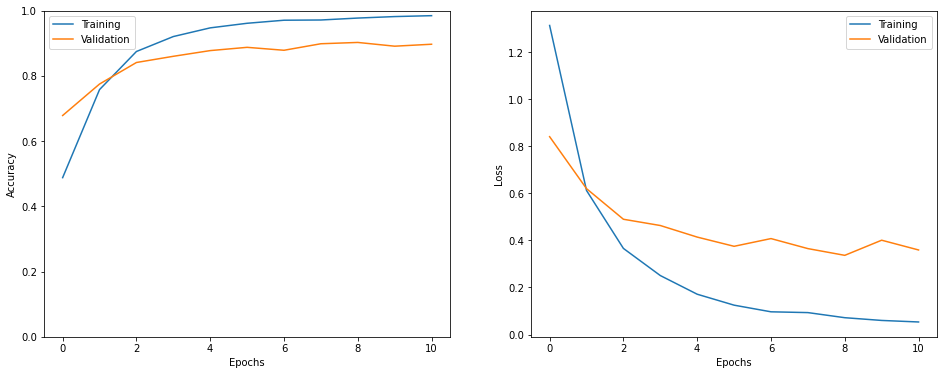

In [34]:
show_history(h)

In [37]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [38]:
pred_eval = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.3657 - accuracy: 0.9040


In [51]:
for x in range(0,3):
    i = random.randint(0, len(test_labels) - 1)
    
    print('Sentence:', test_tweets[i])
    print('Emotion:', index_to_class[test_labels[i]])
    
    p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
    pred_class = index_to_class[np.argmax(p).astype('uint8')]
    
    print('Predicted Emotion:', pred_class, '\n')

Sentence: i mention my oldest child before my youngest will her feelings be hurt
Emotion: sadness
Predicted Emotion: sadness 

Sentence: i was feeling especially shy and awkward because i didn t know many people there
Emotion: fear
Predicted Emotion: fear 

Sentence: i bought the gb iphone i got a apple store credit i feel like they were sympathetic to early buyers and responded appropriately
Emotion: love
Predicted Emotion: love 



In [47]:
preds = np.argmax(model.predict(test_seq), axis = -1)

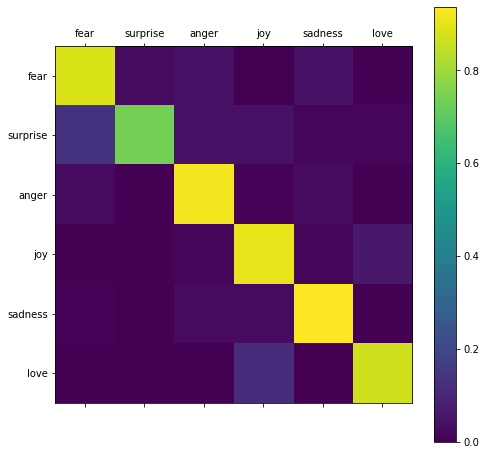

In [48]:
show_confusion_matrix(test_labels, preds, list(classes))